In [2]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

import plotnine as p

Populating the interactive namespace from numpy and matplotlib


/Users/vale/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
grun_path = '/Users/vale/Google\ Drive/Research\ Projects/Finished/Power-analysis/Public\ data/SRP036633/SRP036633_counts.csv'
grun_path = grun_path.replace('\\', '')

In [833]:
counts = pd.read_csv(grun_path, index_col=0)
counts = counts.astype(int)

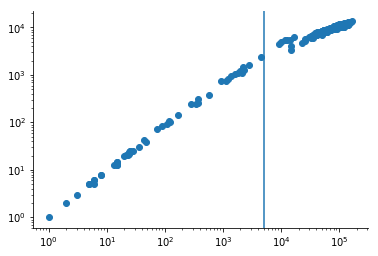

In [834]:
plt.loglog()
plt.scatter(counts.sum(0), (counts > 0).sum(0));
plt.axvline(5e3);

In [835]:
((counts > 0).sum(0) > 5e3).sum()

266

In [837]:
counts = counts.T[((counts > 0).sum(0) > 5e3)].T

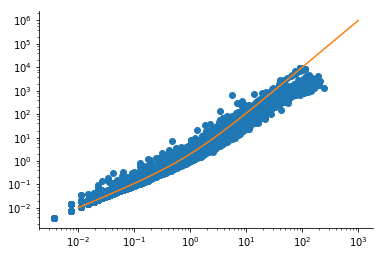

In [1404]:
mm = np.logspace(-2, 3)

plt.loglog()
plt.scatter(counts.mean(1), counts.var(1));
plt.plot(mm, mm + mm ** 2, c='C1');

In [1466]:
idx = counts.pipe(np.log1p).var(1).sort_values(ascending=False).head(500).index

In [1467]:
# idx = counts.sample(1000).index

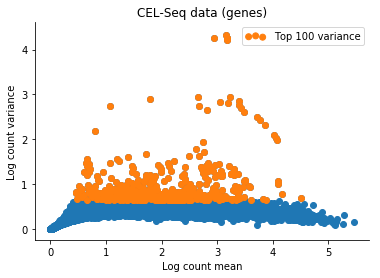

In [1468]:
mus = counts.pipe(np.log1p).mean(1)
vas = counts.pipe(np.log1p).var(1)
plt.scatter(mus, vas, label='');
plt.scatter(mus[idx], vas[idx], label='Top 100 variance');
plt.legend(scatterpoints=3)
plt.xlabel('Log count mean')
plt.ylabel('Log count variance');
plt.title('CEL-Seq data (genes)');

In [1469]:
import pickle

with open('ard-nb-ppca.pkl', 'rb') as fh:
    model = pickle.load(fh)

In [1470]:
x = counts.loc[idx].T.values
N, D = x.shape
data = {
    'N': N,
    'D': D,
    'M': 10,
    'x': x
}

In [1471]:
o = model.optimizing(data=data)

In [1472]:
o['alpha']

array([  6.34365655e+02,   1.02470671e-02,   3.09863986e+02,
         5.09707416e+02,   1.80858880e+03,   1.05441061e+03,
         4.96159770e+02,   7.04278144e+02,   1.45953539e+03,
         3.81522385e+00])

In [1473]:
z = o['z']

In [1474]:
sample_info = counts.columns.str.extractall('(?P<study>.*)_(?P<kind>.*)_(?P<condition>.*)_(?P<replicate>.*)_(?P<barcode>.*)')
sample_info.index = counts.columns

In [1475]:
for i, j in zip(range(z.shape[1]), o['alpha'].argsort()[::-1]):
    sample_info[f'z{i}'] = z[:, j]

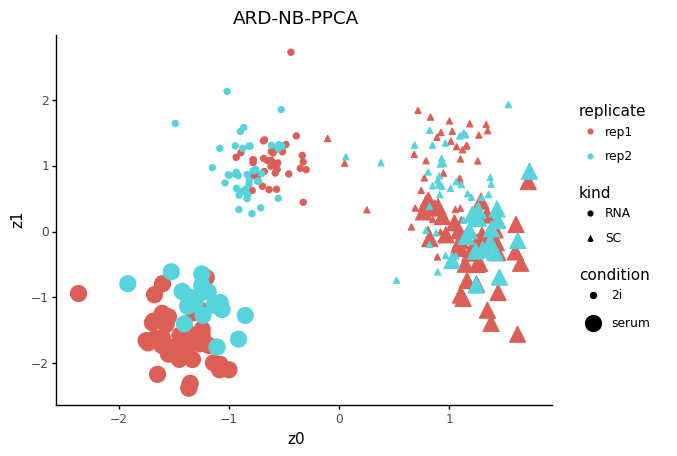

<ggplot: (-9223372036532108649)>

In [1476]:
p.ggplot(sample_info, p.aes('z0', 'z1', color='replicate', shape='kind', size='condition')) \
    + p.geom_point() \
    + p.theme_classic() \
    + p.ggtitle('ARD-NB-PPCA')

In [1477]:
np.exp(o['log_phi'])

1.0

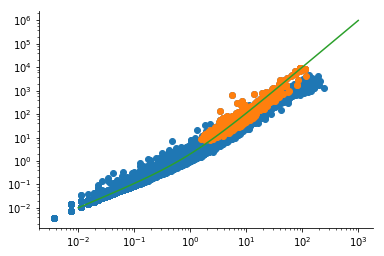

In [1481]:
plt.loglog()
plt.scatter(counts.loc[:].mean(1), counts.loc[:].var(1));
plt.scatter(counts.loc[idx].mean(1), counts.loc[idx].var(1));
plt.plot(mm, mm + np.exp(o['log_phi']) * mm ** 2, c='C2');

In [1479]:
alpha = pd.DataFrame({'alpha': o['alpha'], 'order': o['alpha'].argsort()[::-1].argsort()})

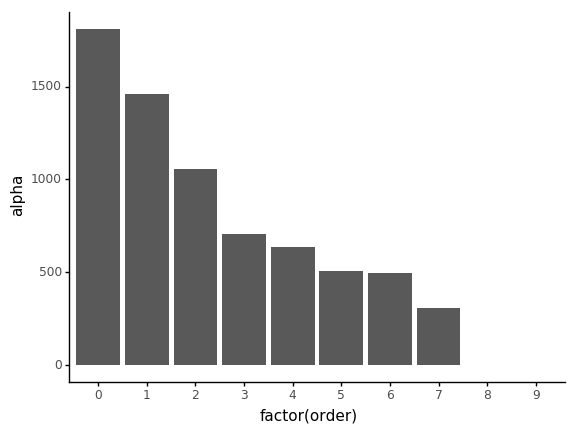

<ggplot: (-9223372036531389878)>

In [1480]:
p.ggplot(alpha, p.aes('factor(order)', 'alpha')) \
    + p.geom_bar(stat='identity') \
    + p.theme_classic()

In [1482]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [1483]:
pca = PCA(n_components=2)

In [1484]:
Y = pca.fit_transform(x)

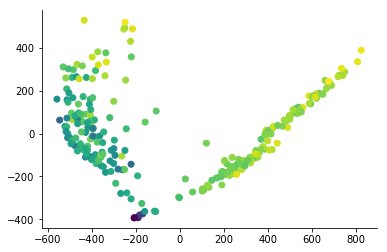

In [1485]:
plt.scatter(Y[:, 0], Y[:, 1], c=s);

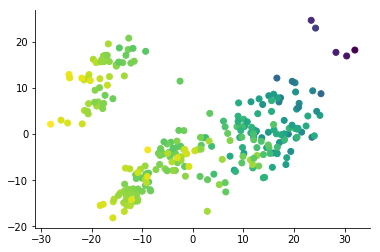

In [1486]:
Y = pca.fit_transform(np.log1p(x))
plt.scatter(Y[:, 0], Y[:, 1], c=s);

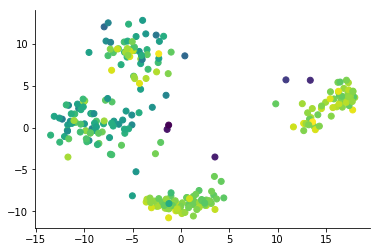

In [1487]:
Y = pca.fit_transform(scale(np.log1p(x), 1))
plt.scatter(Y[:, 0], Y[:, 1], c=s);

In [1488]:
import NaiveDE

In [1489]:
sample_info['total_count'] = x.sum(1)

In [1490]:
x_p = NaiveDE.stabilize(x.T).T
res = NaiveDE.regress_out(sample_info, x_p.T, '~ np.log(total_count)', rcond=1e-8).T

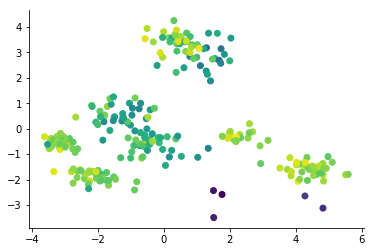

In [1491]:
Y = pca.fit_transform(scale(res, 1))
plt.scatter(Y[:, 0], Y[:, 1], c=s);

In [1492]:
sample_info['PC1'] = Y[:, 0]
sample_info['PC2'] = Y[:, 1]

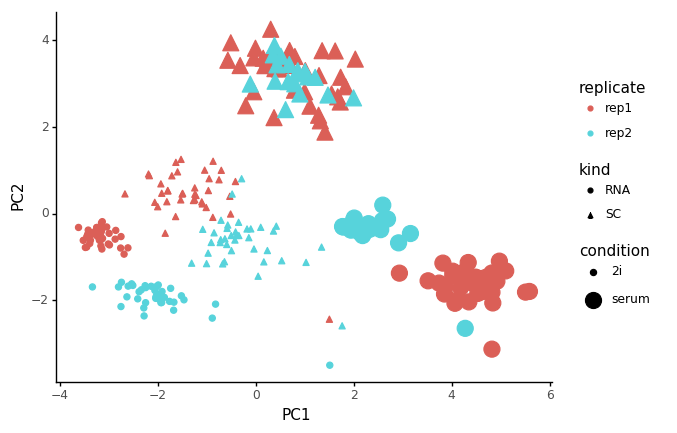

<ggplot: (343875592)>

In [1493]:
p.ggplot(sample_info, p.aes('PC1', 'PC2', color='replicate', shape='kind', size='condition')) \
    + p.geom_point() \
    + p.theme_classic()